In [1]:
# Standard modules
import pickle as pkl
import numpy as np
import heapq as hq
from icecream import ic
# PyTorch
import torch
from torch_geometric.loader import DataLoader
from torch_geometric.data import Batch
from torch_geometric.utils import to_networkx
# NetworkX
import networkx as nx
# RDKit
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.molSize = 300,300
# Matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
# Bokeh
from bokeh.io import output_notebook, show, export_svg
output_notebook()
# Science python
from sklearn.metrics import mean_squared_error
from scipy.stats import wasserstein_distance
# Modules from local files
from GNN_atom import GNN
from Dataset import XASDataset
from train import train_model
from test import test_model
from utils import plot_spectra, plot_learning_curve, bokeh_spectra, calculate_rse

/home/a3782/anaconda3/envs/go_gnn/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loading BokehJS ...

#### Define functions to be used

In [2]:
def train(epoch):
    model.train()
    loss_all = 0
    node_list = []
    select_list = []
    tot_list = []
    smiles_list = []
   # batch_size = 128
    for batch in train_loader:
        
        #print(batch.idx,batch.smiles)
        batch = batch.to(device)
        #x, edge_index,index = batch.x,batch.edge_index,batch.index
       
        #print(batch.idx,batch.atom_index)
        # Add batch dimension to index
        #batch_index = index.unsqueeze(1)

        optimizer.zero_grad()
        
        #pred, node, select, tot = model(batch)
        pred = model(batch)
        batch_size = batch.y.shape[0] // 200
        batch.y = batch.y.view(batch_size, 200)
        #pred = torch.clamp(pred, min=0.0)
        #print(batch.y.shape)
        #new_pred=pred.view(batch.y[:,0:99].shape)

        #pred=ss[0]
        #emb=ss[1]
        alpha = 10

        #loss = nn.MSELoss()(pred.view(-1, 1).double(), 
        #                batch.y[:,:100].view(-1, 1).double()) 
        
        loss = nn.MSELoss()(pred.double(), batch.y.double()) 
       # + alpha*F.mse_loss(torch.log(pred.view(-1, 1).double()+0.001), torch.log(batch.y.view(-1, 1).double()+0.001))
        
        #p_loss=nn.SmoothL1Loss()(new_pred.double(), 
        #                batch.y.double())
        
        #loss=nn.SmoothL1Loss()(pred.view(-1, 1).double(), 
        #                batch.y.view(-1, 1).double())
        #print(loss)
        #print(pred.view(-1, 1).double(), batch.y.view(-1, 1).double())
       # pred_list.append(pred.view(-1, 1).double())
        #y_list.append(batch.y.view(-1, 1).double())
        
        loss.backward()
        #print(batch.num_graphs)
        loss_all += loss.item() * batch.num_graphs
        optimizer.step()
        
        #if epoch == 999 :
        #    node_list.append(node)
        #    select_list.append(select)
        #    smiles_list.append(batch.smiles)
        #    tot_list.append(tot)
    a = 0
    b = 0
    c = 0
    d = 0
    if epoch == 999:
        a = node_list
        b = select_list
        c = smiles_list
        d = tot_list
    
    #print(len(train_loader.dataset))
        #emb_list.append(emb)
    return loss_all / len(train_loader.dataset)#, a ,b ,c ,d

In [3]:
def test(loader):
    model.eval()
    loss_all = 0

    for batch in loader:
        batch = batch.to(device)
        #x, edge_index, index = batch.x, batch.edge_index, batch.index
        
        # Add batch dimension to index
        #batch_index = index.unsqueeze(1)
        batch_size = batch.y.shape[0] // 200
        batch.y = batch.y.view(batch_size, 200)

        with torch.no_grad():
            pred = model(batch)
        
        
        #print(pred)
   #     alpha=10
       # loss = nn.MSELoss()(pred.view(-1, 1).double(),
        #                  batch.y.view(-1, 1).double()) 
        
        loss = nn.MSELoss()(pred.double(),
                          batch.y.double()) 
    #    +alpha*F.mse_loss(torch.log(pred.view(-1, 1).double()+0.001), torch.log(batch.y.view(-1, 1).double()+0.001))
       # loss=nn.SmoothL1Loss()(pred.view(-1, 1).double(), 
       #                 batch.y.view(-1, 1).double())
        loss_all += loss.item() * batch.num_graphs

    return loss_all / len(loader.dataset)

In [4]:
def pred_spec(model, index, test_dataset):
    # Set the model to evaluation mode
    model.eval()

    # Get a single graph from the test dataset
    graph_index = index # Index of the graph you want to predict on
    graph_data = test_dataset[graph_index].to(device)
    batch = Batch.from_data_list([graph_data])

    # Pass the graph through the model
    with torch.no_grad():
        pred = model(batch)

    # Access the predicted output for the single graph
    pred_graph = pred[0]
    true_spectrum = graph_data.y.cpu().numpy()
    predicted_spectrum = pred.cpu().numpy()
    predicted_spectrum = predicted_spectrum.reshape(-1)
    
    return predicted_spectrum, true_spectrum

#### Load dataset

In [5]:
# Path raw directory containing the data
path = "./"
# Load and create the dataset
dataset = XASDataset(path)

In [6]:
# Show detail of the dataset
print(dataset)
print('------------')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')
print('')

# Show details of the first molecule/graph in dataset
data = dataset[0]

print(data)
print('------------')
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

XASDataset(7946)
------------
Number of graphs: 7946
Number of features: 10
Number of classes: 1536450

Data(x=[32, 10], edge_index=[2, 78], y=[200], edge_attrs=[78, 4], vector=[10], idx=[1], smiles='[c:0]12[c:4]3[c:8]4[c:10]5[c:11]([CH:25]=[O:29])[cH:13][c:14]6[c:12]4[c:17]4[c:19]([c:18]([CH:26]=[O:31])[c:15]6[OH:16])=[CH:20][CH:22]6[C:23]([c:21]14)([CH:24]=[CH:1][C:2]2=[CH:3][CH2:5][C:6]3([CH:27]=[O:30])[CH:7]=[CH:9]5)[O:28]6', atom_num=[1], neigbors=[3])
------------
Number of nodes: 32
Number of edges: 78
Average node degree: 2.44
Has isolated nodes: False
Has self loops: False
Is undirected: True


#### View data

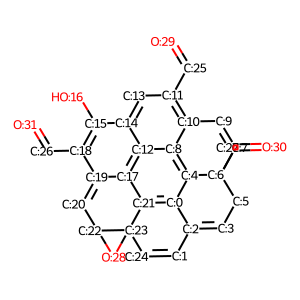

In [7]:
mol = Chem.MolFromSmiles(data.smiles)
mol

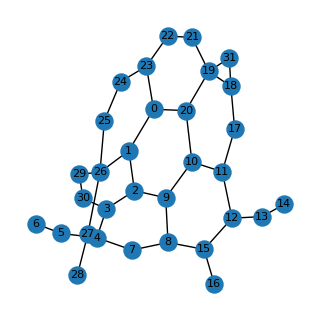

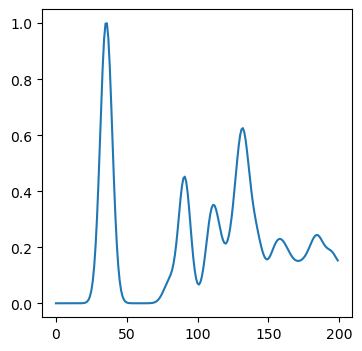

In [8]:
# Show graph representation of molecule
mol_graph = to_networkx(data, to_undirected=True)

plt.figure(figsize=(3,3))

nx.draw(mol_graph, with_labels=True, node_size=150, font_size=8)

plt.show()

# Show an atomic spectrum from molecule
plt.figure(figsize=(4,4))

plt.plot(data.y)

plt.show()

#### Split up dataset

In [9]:
# Split into test, validation and test
train_dataset = dataset[0:300]
val_dataset = dataset[300:330]
test_dataset = dataset[330:375]

# Pass into dataloader
test_loader = DataLoader(test_dataset, batch_size=30, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=30, shuffle=False)
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)

print(f'Length of training data loader: {len(train_loader.dataset)}')
print(f'Length of validation data loader: {len(val_loader.dataset)}')
print(f'Length of testing data loader: {len(test_loader.dataset)}')

Length of training data loader: 300
Length of validation data loader: 30
Length of testing data loader: 45


In [10]:
print(train_loader.dataset[0])
print(train_loader.dataset[0].vector)
print(train_loader.dataset[0].atom_num)
print(train_loader.dataset[0].neigbors)

Data(x=[32, 10], edge_index=[2, 78], y=[200], edge_attrs=[78, 4], vector=[10], idx=[1], smiles='[c:0]12[c:4]3[c:8]4[c:10]5[c:11]([CH:25]=[O:29])[cH:13][c:14]6[c:12]4[c:17]4[c:19]([c:18]([CH:26]=[O:31])[c:15]6[OH:16])=[CH:20][CH:22]6[C:23]([c:21]14)([CH:24]=[CH:1][C:2]2=[CH:3][CH2:5][C:6]3([CH:27]=[O:30])[CH:7]=[CH:9]5)[O:28]6', atom_num=[1], neigbors=[3])
tensor([0.0000, 1.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000,
        0.5781])
tensor([15])
[12, 16, 8]


In [11]:
print(train_loader.dataset[1])
print(train_loader.dataset[1].vector)
print(train_loader.dataset[1].atom_num)
print(train_loader.dataset[1].neigbors)

Data(x=[29, 10], edge_index=[2, 76], y=[200], edge_attrs=[76, 4], vector=[10], idx=[1], smiles='[c:0]12[c:2]3[cH:1][cH:25][c:24]4[c:22]1[c:17]1[c:13]5[c:15]([cH:16][cH:18][c:19]1[c:20]([OH:21])[cH:23]4)[CH:14]1[CH:12]([C:11]4=[C:9]5[C:4]25[C:6]([C:5]([OH:8])=[CH:3]3)([CH:7]2[CH:10]4[O:26]2)[O:28]5)[O:27]1', atom_num=[1], neigbors=[4])
tensor([0.0000, 1.0000, 0.0000, 0.5300, 0.4700, 0.0000, 0.0000, 0.5920, 0.4080,
        0.5920])
tensor([20])
[19, 21, 24, 27]


In [12]:
for batch in train_loader:
    print(batch.x.shape)

torch.Size([32, 10])
torch.Size([29, 10])
torch.Size([29, 10])
torch.Size([29, 10])
torch.Size([28, 10])
torch.Size([31, 10])
torch.Size([28, 10])
torch.Size([28, 10])
torch.Size([31, 10])
torch.Size([32, 10])
torch.Size([29, 10])
torch.Size([32, 10])
torch.Size([29, 10])
torch.Size([27, 10])
torch.Size([28, 10])
torch.Size([28, 10])
torch.Size([29, 10])
torch.Size([29, 10])
torch.Size([29, 10])
torch.Size([29, 10])
torch.Size([29, 10])
torch.Size([29, 10])
torch.Size([34, 10])
torch.Size([31, 10])
torch.Size([33, 10])
torch.Size([29, 10])
torch.Size([28, 10])
torch.Size([29, 10])
torch.Size([33, 10])
torch.Size([31, 10])
torch.Size([33, 10])
torch.Size([31, 10])
torch.Size([30, 10])
torch.Size([32, 10])
torch.Size([28, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([31, 10])
torch.Size([37, 10])
torch.Size([32, 10])
torch.Size([29, 10])
torch.Size([28, 10])
torch.Size([31, 10])
torch.Size([28, 10])
torch.Size([32, 10])
torch.Size([28, 10])
torch.Size([29, 10])
torch.Size([2

#### Set neural network properties

In [13]:
num_tasks = 200
num_layers = 3
emb_dim = dataset.num_features
in_channels = [int(emb_dim), 10, 10]
out_channels = [10, 10, 10]
gnn_type = 'gcn'
heads = int(1)
drop_ratio = 0.8
graph_pooling = 'mean'

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GNN(
    num_tasks,
    num_layers,
    emb_dim,
    in_channels,
    out_channels,
    gnn_type,
    heads,
    drop_ratio,
    graph_pooling,
)
model = model.to(device)
print(model)

GNN(
  (gnn_node): GNN_node(
    (convs): ModuleList(
      (0): GCNConv(10, 10)
      (1): GCNConv(10, 10)
      (2): GCNConv(10, 10)
    )
    (batch_norms): ModuleList(
      (0): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (graph_pred_linear): Linear(in_features=10, out_features=200, bias=True)
  (graph_pred_linear1): Linear(in_features=200, out_features=200, bias=True)
)


In [15]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, betas=(0.9, 0.999), eps=1e-08, amsgrad=True)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=100, min_lr=0.000001)

#### Run neural network training

In [16]:
num_epochs = 1
best_val_error = None
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    
    loss = train_model(epoch, train_loader, model, device, optimizer)
    
    val_error = test_model(val_loader, model, device)
    scheduler.step(val_error)
    #scheduler.step(epoch)
    train_losses.append(loss)
    val_losses.append(val_error)
    
    current_lr = optimizer.param_groups[0]['lr']

    if best_val_error is None or val_error <= best_val_error:
        
        best_val_error = val_error
    if epoch%25 == 0:
        print(f'Epoch: {epoch:03d}, LR: {current_lr:7f}, TrainLoss: {loss:.7f}, ValLoss:{val_error:7f}, Best_ValLoss:{best_val_error:7f}')


ic| h_node.shape: torch.Size([28, 10])
ic| h_node: tensor([[-5.2028, -0.0000, -0.0000, -0.0000,  0.0000, -0.0000, -1.3559, -4.9895,
                     -0.0000, -0.0000],
                    [-0.0000, -0.0000, -0.0000, -2.4722,  0.0000, -0.0000, -0.0000, -0.0000,
                     -0.0000, -0.0000],
                    [-5.2028, -0.0000, -0.0000, -2.1000,  0.0000, -1.6040, -0.0000, -4.9895,
                     -0.0000, -0.0000],
                    [-0.0000, -0.0000, -1.8879, -0.0000,  0.0000, -0.0000, -0.0000, -0.0000,
                     -0.0000, -0.0000],
                    [ 0.0000, -1.3192,  0.0000, -2.4722,  0.0000, -0.0000, -0.0000,  0.0000,
                     -0.0000,  0.0000],
                    [-0.0000, -0.0000, -0.0000, -0.0000,  0.0000, -0.0000, -0.0000,  0.0000,
                      0.0000,  0.0000],
                    [-0.0000, -0.0000, -0.0000, -2.4722,  0.0000, -0.0000, -0.0000, -0.0000,
                      3.6275,  0.0000],
                    [-0.0000, 

NameError: name 'exit' is not defined

In [ ]:
model_name = 'model_gnn_atom_test.pt'
torch.save(model.state_dict(), "ML_models/" + model_name)

#### View loss

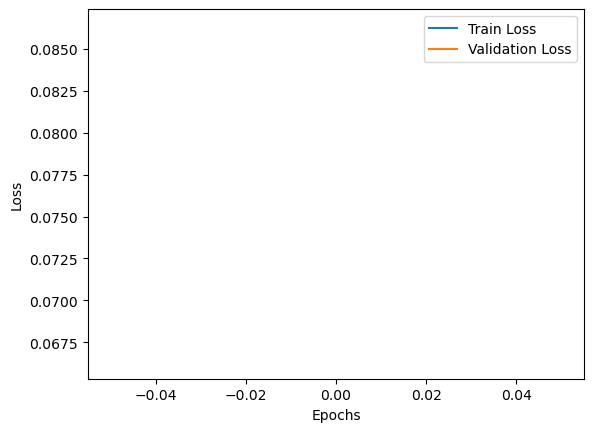

In [ ]:
plot_learning_curve(num_epochs, train_losses, val_losses)

#### Load model and predict spectra

In [ ]:
# Load the saved model
num_tasks = 200

model = GNN(
    num_tasks,
    num_layers,
    emb_dim,
    in_channels,
    out_channels,
    gnn_type,
    heads,
    drop_ratio,
    graph_pooling,
)
mode = model.to(device)
model.load_state_dict(torch.load("ML_models/" + model_name))

<All keys matched successfully>

#### Extract predicted and true spectra

In [ ]:
# Create empty dictionary to contain spectra
predict = {}
true = {}

# Loop over all molecules in test dateset and assign to dictionary index
for index in range(len(test_dataset)):
    predict[index], true[index] = pred_spec(model, index, test_dataset)

# Parse spectra into dictionary
model_dict = [predict, true]

name = 'spectra_ml_atom_test.pkl'

with open('spectra_results/' + name, "wb") as file:
    pkl.dump(model_dict, file)

ic| h_list[0].shape: torch.Size([30, 10])
ic| h_node.shape: torch.Size([30, 200])
ic| h_graph.shape: torch.Size([1, 200])
ic| h_list[0].shape: torch.Size([29, 10])
ic| h_node.shape: torch.Size([29, 200])
ic| h_graph.shape: torch.Size([1, 200])
ic| h_list[0].shape: torch.Size([29, 10])
ic| h_node.shape: torch.Size([29, 200])
ic| h_graph.shape: torch.Size([1, 200])
ic| h_list[0].shape: torch.Size([29, 10])
ic| h_node.shape: torch.Size([29, 200])
ic| h_graph.shape: torch.Size([1, 200])
ic| h_list[0].shape: torch.Size([29, 10])
ic| h_node.shape: torch.Size([29, 200])
ic| h_graph.shape: torch.Size([1, 200])
ic| h_list[0].shape: torch.Size([31, 10])
ic| h_node.shape: torch.Size([31, 200])
ic| h_graph.shape: torch.Size([1, 200])
ic| h_list[0].shape: torch.Size([31, 10])
ic| h_node.shape: torch.Size([31, 200])
ic| h_graph.shape: torch.Size([1, 200])
ic| h_list[0].shape: torch.Size([29, 10])
ic| h_node.shape: torch.Size([29, 200])
ic| h_graph.shape: torch.Size([1, 200])
ic| h_list[0].shape: tor

#### View and analyse predictions

In [ ]:
file = open('spectra_results/' + name, 'rb')
data = pkl.load(file)

predict = data[0]
true = data[1]

In [ ]:
wasser = []
mse = []
rse = []

for x in range(len(predict)):
    # Wasserstein metric
    wass_temp = wasserstein_distance(predict[x], true[x])
    wasser.append(wass_temp)
    # Mean squared error
    mse_temp = mean_squared_error(predict[x], true[x])
    mse.append(mse_temp)
    # RSE
    rse_temp = calculate_rse(predict[x], true[x])
    rse.append(rse_temp)

print(f"Average Wasserstein distance = {sum(wasser) / len(wasser)}")
print(f"Average MSE = {sum(mse) / len(mse)}")
print(f'Average RSE = {sum(rse) / len(rse)}')

Average Wasserstein distance = 0.13916058521500532
Average MSE = 0.08588329507624154
Average RSE = 0.2828451120999597


In [ ]:
five_best = hq.nsmallest(5, rse)
five_worst = hq.nlargest(5, rse)

best = []
worst = []

for x in range(5):
    best_idx = rse.index(five_best[x])
    best.append(best_idx)

    worst_idx = rse.index(five_worst[x])
    worst.append(worst_idx)

print('The 5 best RSE values are:')
for x in range(5):
    print(f'RSE = {five_best[x]:.3f}, graph number = {best[x]}')

print('')
print('The 5 worst RSE values are:')
for x in range(5):
    print(f'RSE = {five_worst[x]:.3f}, graph number = {worst[x]}')

The 5 best RSE values are:
RSE = 0.127, graph number = 17
RSE = 0.173, graph number = 21
RSE = 0.199, graph number = 33
RSE = 0.200, graph number = 2
RSE = 0.204, graph number = 41

The 5 worst RSE values are:
RSE = 0.493, graph number = 26
RSE = 0.428, graph number = 3
RSE = 0.404, graph number = 37
RSE = 0.401, graph number = 38
RSE = 0.384, graph number = 23


In [ ]:
# Plot best spectra prediction
p = bokeh_spectra(predict[best[1]], true[best[1]])
show(p)

In [ ]:
# Plot worst spectra prediction
p = bokeh_spectra(predict[worst[0]], true[worst[0]])
show(p)